# Introduction

[RSGISLib](http://rsgislib.org) has a number image classification modules which allow both pixel and segment (object / clump) based classifications using various machine learning algorithms and libraries.

In this tutorial we will go through the key steps in performing a per-pixel machine learning classification using the [Scikit-Learn](https://scikit-learn.org) library which has many different classification algorithms implemented but also regression algorithms (see other tutorials).

The steps included in this tutorial are:

 * Defining sample data
 * Extract sample data
 * Balance sample data and create training and testing subsets
 * Train classifier
 * Apply classifier



## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_



# 1. Import modules

In [1]:
# Import modules from python standard library
import os
import pprint
import random

# Import Geopandas for vector analysis (https://geopandas.org)
import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

## 1.1 Define the input image files

The input images files are defined:

In [2]:
# Input Sentinel-2 image file with 20 m resolution pixels.
input_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif"

# A valid pixel mask for the input image - this is required for later
# steps but note that for this particular image all the pixel values
# are valid (i.e., there aren't are no data regions).
in_msk_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif"

# 2. Defining Training Samples

Samples are define using polygon or point vector layers, where each layer is defines a single class where multiple polygons/points are used to identify pixels belonging the the class of interest. It should be noted that the vector layer needs to be the same projection as the input image(s).

Samples are defined by either referencing an existing dataset or manually digitising regions using a desktop GIS. [QGIS](https://www.qgis.org) is freely available and easiest to access desktop GIS which can be used for this purpose but other desktop GIS packages (e.g., ArcGIS) are also available.

For this analysis the following Geopackage (GPKG) file as a number of layers defining the training data:


In [3]:
vec_train_file = "../data/cls_data/aber_sen2_cls_training.gpkg"

## 2.1 List the vector layers

To find out which layers are within the vector layer and therefore the classes training data has been provided for this analysis:


In [4]:
# Get the list of layers within the vector file.
lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)

# Print out the layer names by looping through the list of layers returned.
# Note. the enumerate function returns the array index and the list value:
for i, lyr_name in enumerate(lyr_names):
    print(f"{i+1}:\t{lyr_name}")

1:	Artificial_Surfaces
2:	Bare_Rock_Sand
3:	Conifer_Forest
4:	Deciduous_Forest
5:	Grass_Long
6:	Grass_Short
7:	NonPhotosynthetic_Vegetation
8:	Scrub
9:	Water_Training
10:	Bracken


## Visualise the training data

It is recommended that you open the input image (`sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif`) and training samples (`aber_sen2_cls_training.gpkg`) in QGIS (or equivlent) to see the regions which have been defined for training as this allows you to manipulate (i.e., pan and zoom) the data.

However, an overview visualisation is shown below for illustration. If you change the bounding box you can pan and zoom around scene.


In [5]:
# Get the full image bounding box.
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)
print(img_bbox)

[249177.3321426216, 315077.3321426216, 268742.255157026, 326342.255157026]


Image Data Size: 1250 x 1250


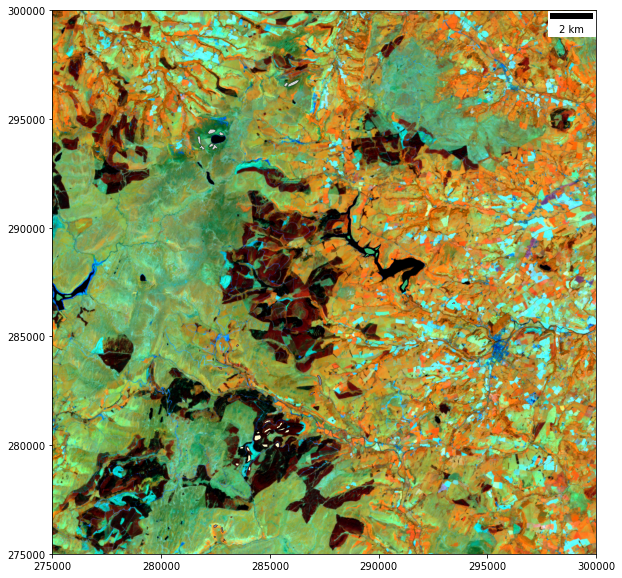

In [6]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [275000, 300000, 275000, 300000]

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

rsgislib.tools.mapping.create_raster_img_map(
    ax,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar = True)

# Get a list of available colours within matplotlib
mpl_clrs = list(mcolors.CSS4_COLORS.keys())

gp_vecs = list()
lyr_clrs = list()
for i, lyr_name in enumerate(lyr_names):
    # Read samples to geopandas dataframe
    gp_vecs.append(geopandas.read_file(vec_train_file, layer=lyr_name))
    # Select a random colour
    lyr_clrs.append(random.choice(mpl_clrs))

rsgislib.tools.mapping.create_vec_lyr_map(
    ax,
    gp_vecs=gp_vecs,
    bbox=sub_img_bbox,
    vec_fill_clrs=lyr_clrs,
    vec_line_clrs= "black",
    show_scale_bar = False,
)

# 3. Extract Training Samples

For the analysis, individual pixel values are extracted and stored in a [HDF5](https://www.hdfgroup.org/solutions/hdf5/) which allows for that data to be stored and manipulated (e.g., pixels values from multiple images can be merged).

To extract the training samples (i.e., individual pixel values) using the defined vector layer the vector layers first need to be rasterised to the same pixel grid as the input image(s). To simplify the implementation of this a helper function has been provided: `rsgislib.classification.get_class_training_data`. This tutorial will therefore make use of this helper function.




## 3.1 Define Images and Bands for Classification

Before the image pixel values can be extracted or the classification performed the relevant images and bands within those images need to be defined. Clearly, these need to defined identically for both extracting the image samples and the classification step. If these are not identically defined then the trained classifer will not work as intended which is likely to produce very poor classification results.

To define the images and bands a list of `rsgislib.imageutils.ImageBandInfo` objects is provided to the relevant RSGISLib functions:


In [7]:
img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)

## 3.2 Define the classes and the vector samples

For the helper function the class names and vector layers needed to be define as a list of `rsgislib.classification.ClassVecSamplesInfoObj` objects:

> Note. the `id` will be the output pixel value for the class in the output image.


In [8]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
artificial_surfaces_h5 = "artificial_surfaces_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="artificial_surfaces",
        vec_file=vec_train_file,
        vec_lyr="Artificial_Surfaces",
        file_h5=artificial_surfaces_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
bare_rock_sand_h5 = "bare_rock_sand_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="bare_rock_sand",
        vec_file=vec_train_file,
        vec_lyr="Bare_Rock_Sand",
        file_h5=bare_rock_sand_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
conifer_forest_h5 = "conifer_forest_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="conifer_forest",
        vec_file=vec_train_file,
        vec_lyr="Conifer_Forest",
        file_h5=conifer_forest_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
deciduous_forest_h5 = "deciduous_forest_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="deciduous_forest",
        vec_file=vec_train_file,
        vec_lyr="Deciduous_Forest",
        file_h5=deciduous_forest_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
grass_long_h5 = "grass_long_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="grass_long",
        vec_file=vec_train_file,
        vec_lyr="Grass_Long",
        file_h5=grass_long_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
grass_short_h5 = "grass_short_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=6,
        class_name="grass_short",
        vec_file=vec_train_file,
        vec_lyr="Grass_Short",
        file_h5=grass_short_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
nonphoto_veg_h5 = "nonphoto_veg_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=7,
        class_name="nonphoto_veg",
        vec_file=vec_train_file,
        vec_lyr="NonPhotosynthetic_Vegetation",
        file_h5=nonphoto_veg_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
scrub_h5 = "scrub_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=8,
        class_name="scrub",
        vec_file=vec_train_file,
        vec_lyr="Scrub",
        file_h5=scrub_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
water_h5 = "water_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=9,
        class_name="water",
        vec_file=vec_train_file,
        vec_lyr="Water_Training",
        file_h5=water_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
bracken_h5 = "bracken_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=10,
        class_name="bracken",
        vec_file=vec_train_file,
        vec_lyr="Bracken",
        file_h5=bracken_h5,
    )
)

## 3.3 Create a temporary output directory

The helper function requires a directory for temporary outputs (e.g., rastered vector layers) to be written to during the processing. The following code will test as to whether the directory already exists and if not it will created it:

In [9]:
tmp_dir = "./tmp"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

## 3.4 Perform Sample Extraction

The next step will now use the `rsgislib.classification.get_class_training_data` helper function to extract the sample data:


In [10]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_info, tmp_dir, ref_img=in_msk_img
)

Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Creating output image using input image
Running Rasterise now...


Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running R

In [11]:
# Output the returned class samples info object - note the colours have been randomly assigned:
cls_smpls_info

{'artificial_surfaces': 1: artificial_surfaces_smpls.h5, (64, 33, 167),
 'bare_rock_sand': 2: bare_rock_sand_smpls.h5, (237, 41, 46),
 'conifer_forest': 3: conifer_forest_smpls.h5, (58, 117, 64),
 'deciduous_forest': 4: deciduous_forest_smpls.h5, (248, 125, 164),
 'grass_long': 5: grass_long_smpls.h5, (253, 227, 4),
 'grass_short': 6: grass_short_smpls.h5, (22, 226, 97),
 'nonphoto_veg': 7: nonphoto_veg_smpls.h5, (166, 229, 183),
 'scrub': 8: scrub_smpls.h5, (174, 160, 45),
 'water': 9: water_smpls.h5, (215, 75, 136),
 'bracken': 10: bracken_smpls.h5, (42, 6, 135)}

## 3.5 Define Class Colours

It is useful to manual define colours for classes is it makes it much easier for the end user to interpret the map. Colours are define as Red, Green and Blue (RGB) values between 0-255. There are many tools to look up colour online (try searching 'Colour picker').


In [12]:
cls_smpls_info["artificial_surfaces"].red = 180
cls_smpls_info["artificial_surfaces"].green = 180
cls_smpls_info["artificial_surfaces"].blue = 180

cls_smpls_info["bare_rock_sand"].red = 131
cls_smpls_info["bare_rock_sand"].green = 250
cls_smpls_info["bare_rock_sand"].blue = 252

cls_smpls_info["conifer_forest"].red = 0
cls_smpls_info["conifer_forest"].green = 105
cls_smpls_info["conifer_forest"].blue = 16

cls_smpls_info["deciduous_forest"].red = 62
cls_smpls_info["deciduous_forest"].green = 168
cls_smpls_info["deciduous_forest"].blue = 78

cls_smpls_info["grass_long"].red = 247
cls_smpls_info["grass_long"].green = 176
cls_smpls_info["grass_long"].blue = 32

cls_smpls_info["grass_short"].red = 252
cls_smpls_info["grass_short"].green = 231
cls_smpls_info["grass_short"].blue = 109

cls_smpls_info["nonphoto_veg"].red = 156
cls_smpls_info["nonphoto_veg"].green = 255
cls_smpls_info["nonphoto_veg"].blue = 215

cls_smpls_info["scrub"].red = 225
cls_smpls_info["scrub"].green = 114
cls_smpls_info["scrub"].blue = 247

cls_smpls_info["water"].red = 0
cls_smpls_info["water"].green = 0
cls_smpls_info["water"].blue = 255

cls_smpls_info["bracken"].red = 140
cls_smpls_info["bracken"].green = 255
cls_smpls_info["bracken"].blue = 0

cls_smpls_info

{'artificial_surfaces': 1: artificial_surfaces_smpls.h5, (180, 180, 180),
 'bare_rock_sand': 2: bare_rock_sand_smpls.h5, (131, 250, 252),
 'conifer_forest': 3: conifer_forest_smpls.h5, (0, 105, 16),
 'deciduous_forest': 4: deciduous_forest_smpls.h5, (62, 168, 78),
 'grass_long': 5: grass_long_smpls.h5, (247, 176, 32),
 'grass_short': 6: grass_short_smpls.h5, (252, 231, 109),
 'nonphoto_veg': 7: nonphoto_veg_smpls.h5, (156, 255, 215),
 'scrub': 8: scrub_smpls.h5, (225, 114, 247),
 'water': 9: water_smpls.h5, (0, 0, 255),
 'bracken': 10: bracken_smpls.h5, (140, 255, 0)}

## 3.6 How many training samples were extracted:

To find out how many training samples were extracted the following code will loop through the `cls_smpls_info` dict and print out the number of samples:


In [13]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

artificial_surfaces: 454
bare_rock_sand: 5392
conifer_forest: 3335
deciduous_forest: 4021
grass_long: 1264
grass_short: 622
nonphoto_veg: 1989
scrub: 5961
water: 34232
bracken: 1399


Observing the number of samples which are available for the classes there are a number of things which could be done. First, the samples should be balance (i.e., the same number per-class) and this would require using the class with the minimum of samples as the reference for defining the number of testing, training and validation samples. Alternatively, the sample data can be oversampled or there are algorithms which attempt to generate artifical training samples (see the functions within the `rsgislib.classification.classimblearn` module which make use of the [imbalanced-learn](https://imbalanced-learn.org) library.

For this tutorial, things will be kept simple and the class (artificial_surfaces) with the lowest number of samples will be used to define the number of samples for each class:

 * Training: 350
 * Validation: 50
 * Testing: 50
 
 The samples are randomly selected from the population of input samples.


## 3.7 Balance and Extract Training / Validation and Testing datasets

Again a helper function (`rsgislib.classication.create_train_valid_test_sets`) has been provided which will make it simplier to perform this analysis. For this a list of `rsgislib.classification.ClassInfoObj` objects needs to be defined which specifies the file names for the training, validation and testing HDF5 files.

In this case, using the `get_class_info_dict` function the existing dictionary (`cls_smpls_info`) will be looped through and file names automatically defined by adding either `_train`, `_valid` or `_test` to the existing file name for the HDF5 file.


In [14]:
# Define the output directory and create if it does not exist:
smpls_dir = "./cls_smpls"

if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)


cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(cls_smpls_info, smpls_dir)


0=1: (Train:./cls_smpls/artificial_surfaces_smpls_train.h5, Test:./cls_smpls/artificial_surfaces_smpls_test.h5, Valid:./cls_smpls/artificial_surfaces_smpls_valid.h5), (180, 180, 180)
1=2: (Train:./cls_smpls/bare_rock_sand_smpls_train.h5, Test:./cls_smpls/bare_rock_sand_smpls_test.h5, Valid:./cls_smpls/bare_rock_sand_smpls_valid.h5), (131, 250, 252)
2=3: (Train:./cls_smpls/conifer_forest_smpls_train.h5, Test:./cls_smpls/conifer_forest_smpls_test.h5, Valid:./cls_smpls/conifer_forest_smpls_valid.h5), (0, 105, 16)
3=4: (Train:./cls_smpls/deciduous_forest_smpls_train.h5, Test:./cls_smpls/deciduous_forest_smpls_test.h5, Valid:./cls_smpls/deciduous_forest_smpls_valid.h5), (62, 168, 78)
4=5: (Train:./cls_smpls/grass_long_smpls_train.h5, Test:./cls_smpls/grass_long_smpls_test.h5, Valid:./cls_smpls/grass_long_smpls_valid.h5), (247, 176, 32)
5=6: (Train:./cls_smpls/grass_short_smpls_train.h5, Test:./cls_smpls/grass_short_smpls_test.h5, Valid:./cls_smpls/grass_short_smpls_valid.h5), (252, 231, 109

In [15]:
# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 50, 50, 350
)

# 4. Train the Classifier


## 4.1 Optimise Classifier Parameters

The first step is to define the search space


In [16]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100, 150, 200],
        "max_depth": [4, 8, 10, 12, 14, 16],
    },
)

sk_classifier = rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
    cls_smpls_fnl_info, grid_search
)

Training data size: 534 x 10
Best score was 0.9531475930171045 and has parameters {'max_depth': 10, 'n_estimators': 100}.


## 4.2 Train Optimised Classifier


In [17]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 3540 x 10
Testing data size: 534 x 10
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 99.44%
Classifier Test Score = 98.13%


(0.9943502824858758, 0.9812734082397003)

# 5. Apply Classifier

In [18]:
out_cls_img = "sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_cls.kea"
out_scr_img = "sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_cls_score.kea"

rsgislib.classification.classsklearn.apply_sklearn_classifier(
    cls_smpls_fnl_info,
    sk_classifier,
    in_img_mask=in_msk_img,
    img_mask_val=1,
    img_file_info=img_band_info,
    output_img=out_cls_img,
    gdalformat="KEA",
    class_clr_names=True,
    out_score_img=out_scr_img,
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Calculating Image Pyramids.










Apply Colour to class 'artificial_surfaces'
Apply Colour to class 'bare_rock_sand'
Apply Colour to class 'conifer_forest'
Apply Colour to class 'deciduous_forest'
Apply Colour to class 'grass_long'
Apply Colour to class 'grass_short'
Apply Colour to class 'nonphoto_veg'
Apply Colour to class 'scrub'
Apply Colour to class 'water'
Apply Colour to class 'bracken'


# 6. Visual Classification Results

Image Data Size: 3295 x 2880


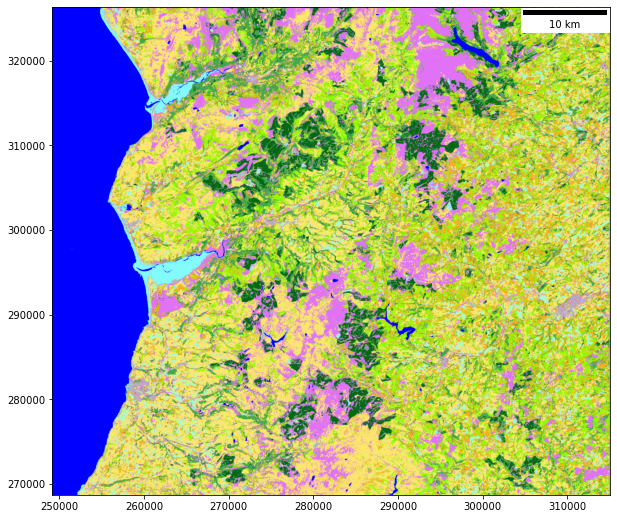

In [19]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

rsgislib.tools.mapping.create_thematic_raster_map(ax, out_cls_img)

## 6.1 Visualise Subsets

Image Data Size: 1250 x 1250
Image Data Size: 1250 x 1250


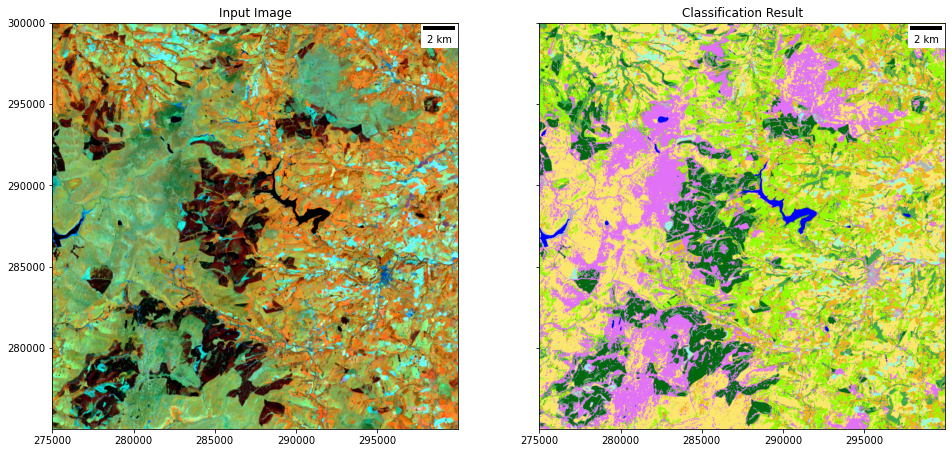

In [20]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [275000, 300000, 275000, 300000]
#sub_img_bbox = [255000, 280000, 275000, 300000]
#sub_img_bbox = [295000, 300000, 295000, 300000]

# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Add the Sentinel-2 image to the axis
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar = True)
ax1.title.set_text("Input Image")

# Add the classification to the seocnd axis.
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img, bbox=sub_img_bbox)
ax2.title.set_text("Classification Result")


## 6.2 Create Legend

In [21]:
# Import functions from a local file which will be included in RSGISLib
# v5.0.11 or higher within the rsgislib.tools.plotting module
from legend_plotting import *

Max. characters in class name: 19
Column width: 126
Image: 264 x  130


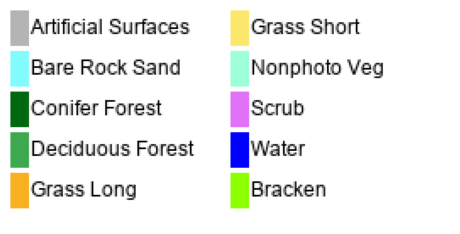

In [22]:
cls_info = create_legend_info_dict(out_cls_img, cls_names_col="class_names", use_title_case=True, underscore_to_space=True)

# Just display the legend using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
create_legend_img_mpl_ax(
        ax,
        legend_info=cls_info,
        n_cols = 2)

In [23]:
# There is a similar function which allows the legend to be saved to an image file:
create_legend_img_file("legend_img_file.png", legend_info=cls_info, n_cols = 2)

Max. characters in class name: 19
Column width: 126
Image: 264 x  130


## 6.3 Show Legend Alongside Map

Image Data Size: 1250 x 1250
Image Data Size: 1250 x 1250
Max. characters in class name: 19
Column width: 126
Image: 264 x  130


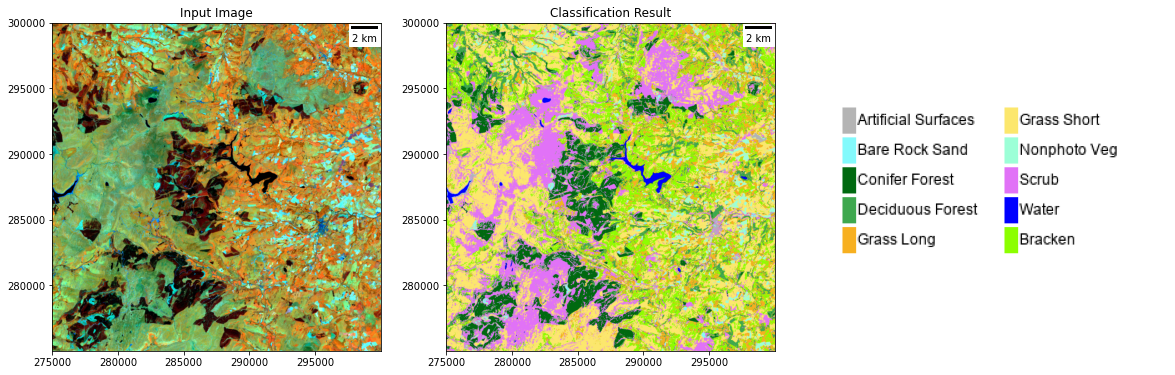

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
# Add the Sentinel-2 image to the axis
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar = True)
ax1.title.set_text("Input Image")

# Add the classification to the seocnd axis.
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img, bbox=sub_img_bbox)
ax2.title.set_text("Classification Result")

create_legend_img_mpl_ax(
        ax3,
        legend_info=cls_info,
        n_cols = 2)